In [14]:
import numpy as np 
import bagpipes as pipes
from astropy.table import Table
from astropy.io import ascii, fits
import matplotlib.pyplot as plt

### load filter curves

In [4]:
#normalize u band, and convert nm to angstroms
u_band = ascii.read('hsc_responses_all_rev3/cfh9301.dat')
u_band['col1'] = u_band['col1']*10.
u_band['col2'] = u_band['col2']/100.
u_band.reverse()
np.savetxt('hsc_responses_all_rev3/cfh9301_norm.txt', u_band, fmt='%9.3f')

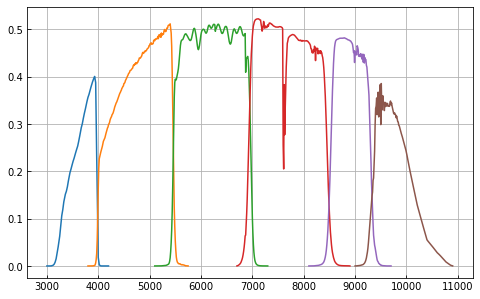

In [2]:
#clauds/hsc filter curves 
curve_u = 'hsc_responses_all_rev3/U.MP9302.txt'
curve_g = 'hsc_responses_all_rev3/hsc_g_v2018.dat'
curve_r = 'hsc_responses_all_rev3/hsc_r_v2018.dat'
curve_i = 'hsc_responses_all_rev3/hsc_i_v2018.dat'
curve_z = 'hsc_responses_all_rev3/hsc_z_v2018.dat'
curve_y = 'hsc_responses_all_rev3/hsc_y_v2018.dat'

#plot with new u_band
# curve_u = 'hsc_responses_all_rev3/cfh9301_norm.txt'
filt_list = [curve_u,curve_g,curve_r,curve_i,curve_z,curve_y]
plt.figure(figsize = (8, 5))
for filt in filt_list:
    fi = ascii.read(filt)
    plt.plot(fi['col1'], fi['col2'], '-')
plt.grid()
plt.show()


[SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php)

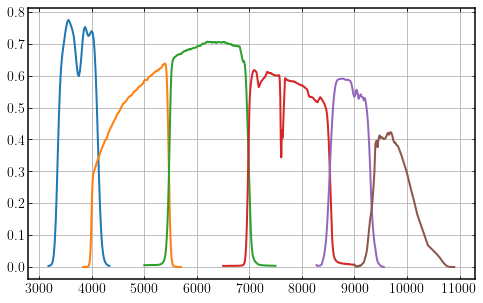

In [86]:
# redefine filt_list (from SVO)  and plot
curve_u = 'filters_new/CFHT_Megaprime.u.txt'
curve_g = 'filters_new/Subaru_HSC.g.txt'
curve_r = 'filters_new/Subaru_HSC.r.txt'
curve_i = 'filters_new/Subaru_HSC.i.txt'
curve_z = 'filters_new/Subaru_HSC.z.txt'
curve_y = 'filters_new/Subaru_HSC.Y.txt'
filt_list_new = [curve_u,curve_g,curve_r,curve_i,curve_z,curve_y]

plt.figure(figsize = (8, 5))
for filt in filt_list_new:
    fi = ascii.read(filt)
    plt.plot(fi['col1'], fi['col2'], '-')
plt.grid()
plt.show()


### make model galaxy (from example1)

In [3]:
exp = {}                          # Tau model star formation history component
exp["age"] = 5.                   # Gyr
exp["tau"] = 0.75                 # Gyr
exp["massformed"] = 9.            # log_10(M*/M_solar)
exp["metallicity"] = 0.5          # Z/Z_oldsolar

dust = {}                         # Dust component
dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
dust["Av"] = 0.2                  # magnitudes

model_components = {}                   # The model components dictionary
model_components["redshift"] = 1.0      # Observed redshift  
model_components["exponential"] = exp   
model_components["dust"] = dust

In [10]:
goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")
model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list)

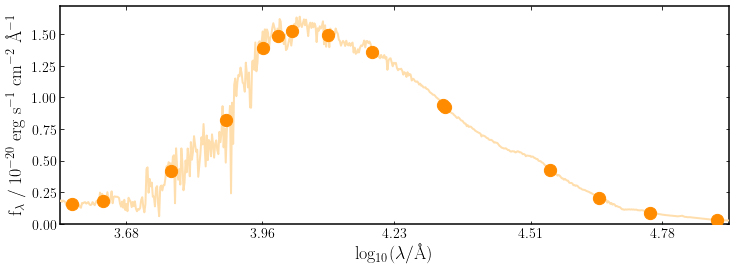

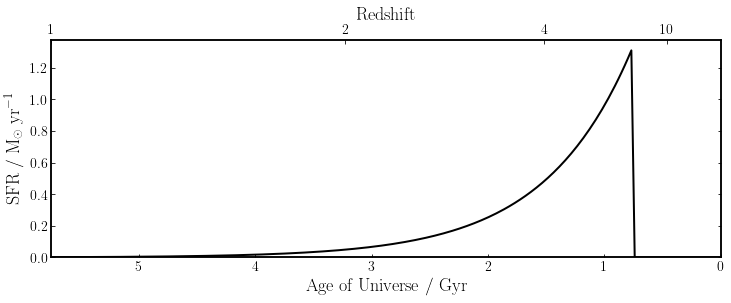

In [11]:
fig = model.plot()
fig = model.sfh.plot()

### photometry data fit from CLAUDS

In [3]:
# cat = Table.read('CUT_deep_catalogs/s16a_DEEP_deep_masterCat.fits')
cat = Table.read('CUT_deep_catalogs/deep2_photoz_v2.fits')

In [4]:
def Jy2ab(flux):
    return 2.5*(23-np.log10(flux))-48.6

def ab2Jy(mag):
    return 10**(23-(mag+48.6)/2.5)

def aberr2Jy(mag,magerr):
    return 5811.33*np.e**(-0.921034*mag)*magerr

def load_gal(ID):
    cat = Table.read('CUT_deep_catalogs/deep2_photoz_v2.fits')
    gal = cat[cat['ID']==ID]
    u, g, r, i, z, y = gal['MAG_APER_2s_u'],gal['MAG_APER_2s_g'],gal['MAG_APER_2s_r'],gal['MAG_APER_2s_i'],gal['MAG_APER_2s_z'],gal['MAG_APER_2s_y']
    uerr, gerr, rerr, ierr, zerr, yerr = gal['MAGERR_APER_2s_u'],gal['MAGERR_APER_2s_g'],gal['MAGERR_APER_2s_r'],gal['MAGERR_APER_2s_i'],gal['MAGERR_APER_2s_z'],gal['MAGERR_APER_2s_y']
    mags = np.array([u, g, r, i, z, y])
    print(mags)
    magerrs = np.array([uerr, gerr, rerr, ierr, zerr, yerr]) 
    
    # mag correction (Sawicki & Yee 1997)
    i_corr = gal['i'] - gal['MAG_APER_2s_i'] 
    mags = mags + i_corr
    magerrs = np.sqrt(gal['i_err']**2 + gal['MAGERR_APER_2s_i']**2)
    
    fluxes = ab2Jy(mags)
    fluxerrs = aberr2Jy(mags,magerrs)
    photometry = np.c_[fluxes,fluxerrs]
    
    # NaNs and 0s
    for i in range(len(photometry)):
        photometry[i, 0] = photometry[i, 0]*1e6
        photometry[i, 1] = photometry[i, 1]*1e6
        if (photometry[i, 0] <= 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**9.]
    
    # Enforce a maximum SNR of 20.
    for i in range(len(photometry)):
        max_snr = 20.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr
            
    return photometry

In [133]:
def load_gal2(id_gal):
    id_gal = int(id_gal)
    
    #catalog
    catf = fits.open('CUT_deep_catalogs/s16a_DEEP_deep_masterCat.fits')
    cat = catf[1].data
    
    #obj
    cat_obj = cat[cat['NUMBER']==id_gal]
    
    #get fluxes and errors of obj
    fluxes = ['FLUX_TOT_MegaCam_u', 'FLUX_TOT_HSC_G', 'FLUX_TOT_HSC_R', 'FLUX_TOT_HSC_I', 'FLUX_TOT_HSC_Z', 'FLUX_TOT_HSC_Y']
    flux_errors = ['FLUXERR_TOT_MegaCam_u', 'FLUXERR_TOT_HSC_G', 'FLUXERR_TOT_HSC_R', 'FLUXERR_TOT_HSC_I', 'FLUXERR_TOT_HSC_Z', 'FLUXERR_TOT_HSC_Y']

    fluxes_obj = np.array([cat_obj[fname]*1e6 for fname in fluxes])
    fluxes_err_obj = np.array([cat_obj[fname]*1e6 for fname in flux_errors])
    
    #give 0 flux and large error to filters with bad photometry
    fluxes_obj[(fluxes_obj<=0)|(fluxes_err_obj<=0)] = 0                 #0         np.nan
    fluxes_err_obj[(fluxes_obj<=0)|(fluxes_err_obj<=0)] = 9.9*10**99    #np.inf    np.nan
    
    phot = np.c_[fluxes_obj, fluxes_err_obj]
    
    return phot

In [116]:
ID = cat[60919]['ID']
galaxy = pipes.galaxy(ID, load_gal, spectrum_exists=False, filt_list = filt_list)
####ADDED
# galaxy2 = pipes.galaxy(ID, load_gal2, spectrum_exists=False, filt_list = filt_list_new)
# galaxy3 = pipes.galaxy(ID, load_gal3, spectrum_exists=False, filt_list = filt_list_new)


[[23.751919]
 [22.821371]
 [22.10822 ]
 [21.794909]
 [21.660805]
 [21.599627]]


In [5]:
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

fit_instructions = {}         
# The fit instructions dictionary
fit_instructions["redshift"] = (0.2, 5.0)  # Vary observed redshift from 0 to 10
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust


Bagpipes: fitting object 0360920


Completed in 78.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.158      0.421      1.214
exponential:age                1.852      5.941      9.186
exponential:massformed         9.420      9.579     11.881
exponential:metallicity        0.048      0.146      0.614
exponential:tau                2.809      5.259      8.179
redshift                       0.217      0.246      2.291




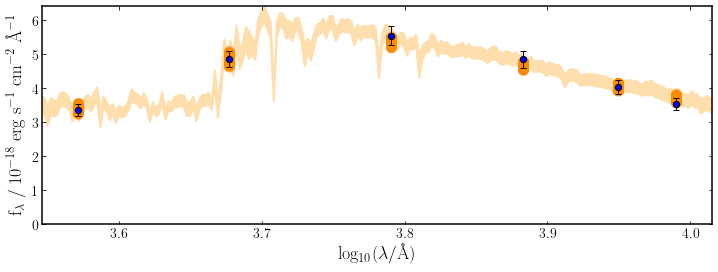

In [119]:
fit = pipes.fit(galaxy, fit_instructions, run="vvev")
fit.fit(verbose=False)
fig = fit.plot_spectrum_posterior(save=False, show=True)

In [19]:
####ADDED
fit2 = pipes.fit(galaxy2, fit_instructions, run="2")
fit2.fit(verbose=True)


Bagpipes: fitting object 9463260011993


Completed in 18.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.301      0.745      1.261
exponential:age                1.688      3.752      5.803
exponential:massformed         8.168      8.670      9.112
exponential:metallicity        0.553      1.422      2.131
exponential:tau                3.255      6.134      8.648
redshift                       0.529      0.748      0.914




In [20]:
####ADDED
fit3 = pipes.fit(galaxy3, fit_instructions, run="3")
fit3.fit(verbose=True)


Bagpipes: fitting object 9463260011993


Completed in 69.5 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.056      0.189      0.447
exponential:age                3.452      4.803      5.813
exponential:massformed        11.127     11.223     11.306
exponential:metallicity        1.103      1.620      2.055
exponential:tau                0.461      0.638      0.775
redshift                       0.869      0.887      0.910




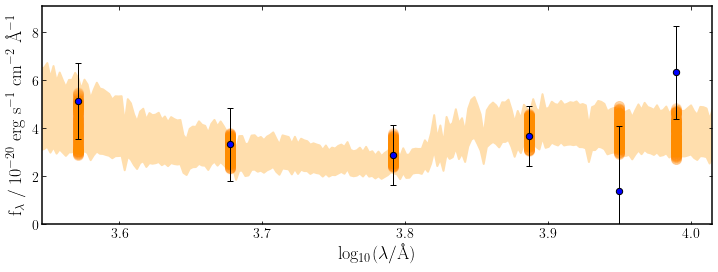

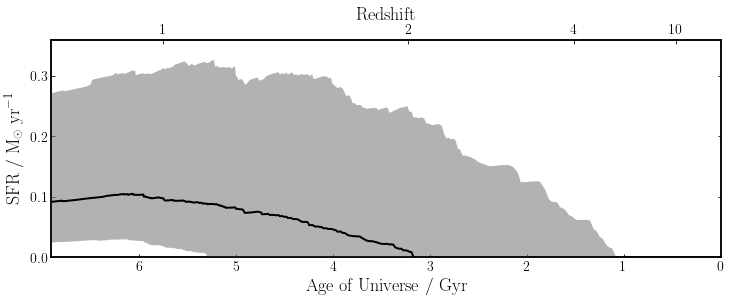

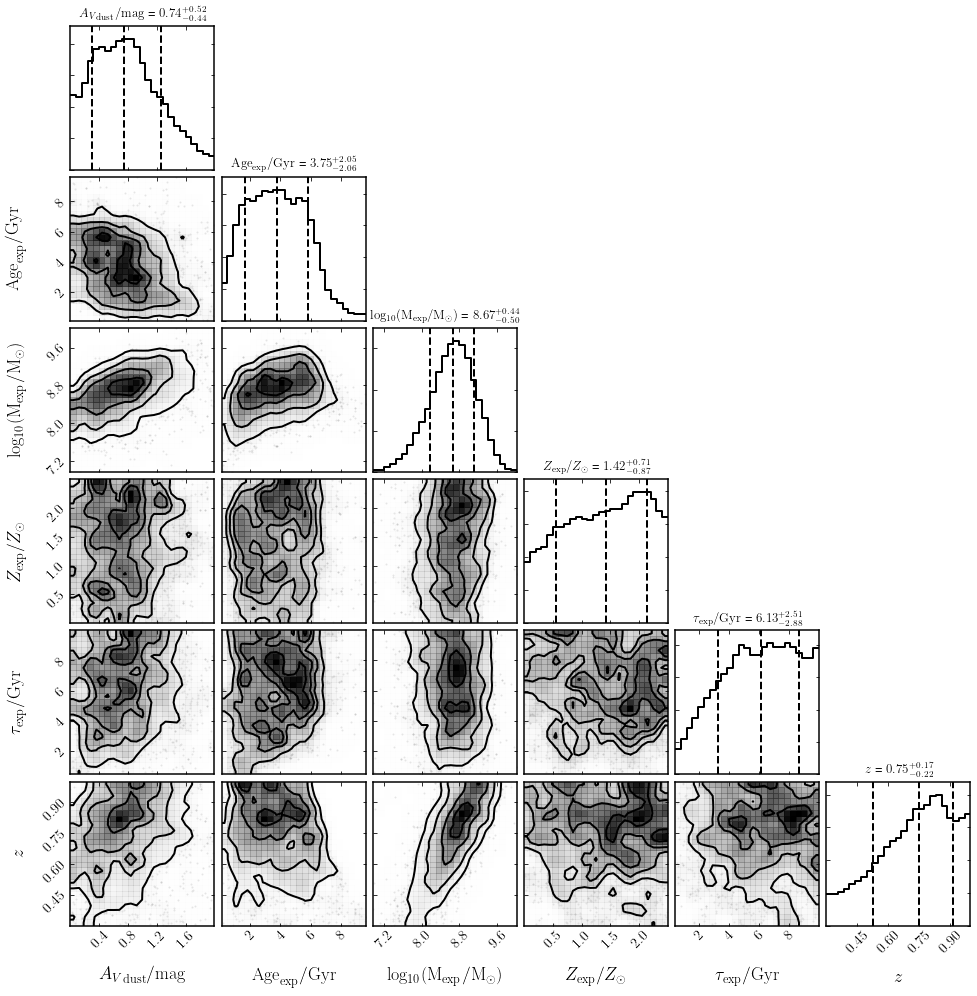

In [228]:
####ADDED
fig = fit2.plot_spectrum_posterior(save=False, show=True)
fig = fit2.plot_sfh_posterior(save=False, show=True)
fig = fit2.plot_corner(save=False, show=True)

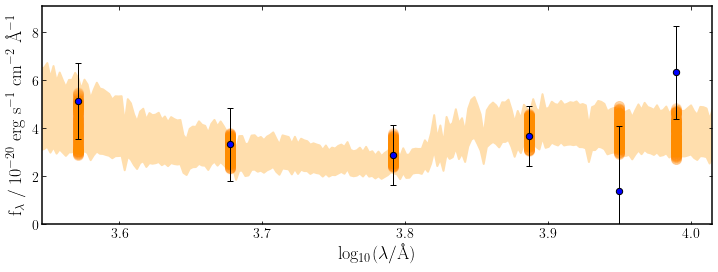

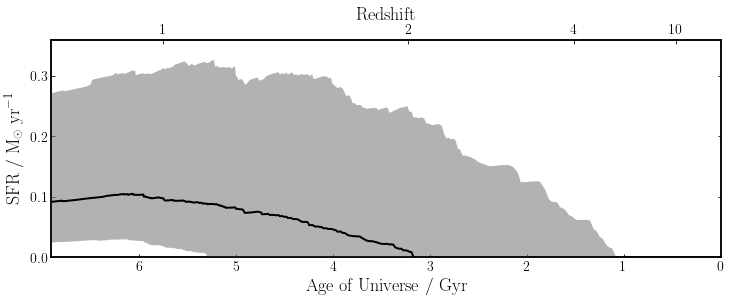

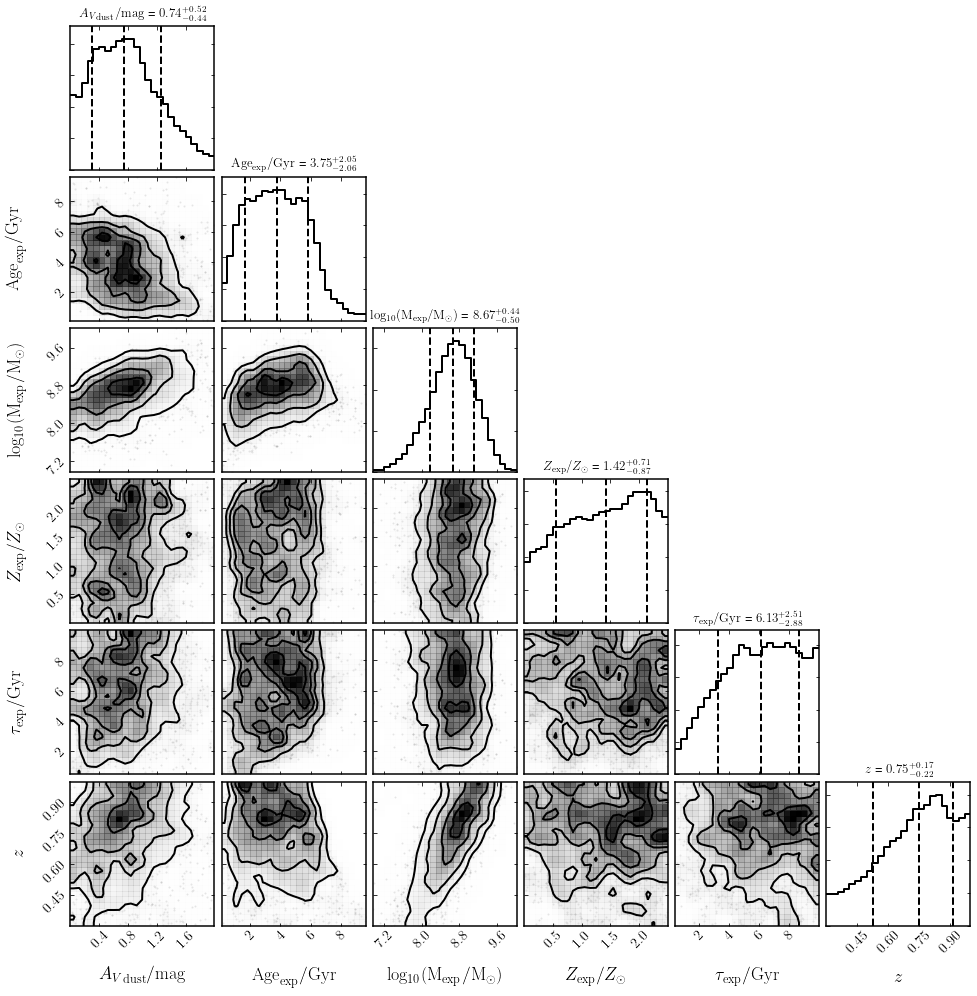

In [22]:
####ADDED
fig = fit2.plot_spectrum_posterior(save=False, show=True)
fig = fit2.plot_sfh_posterior(save=False, show=True)
fig = fit2.plot_corner(save=False, show=True)

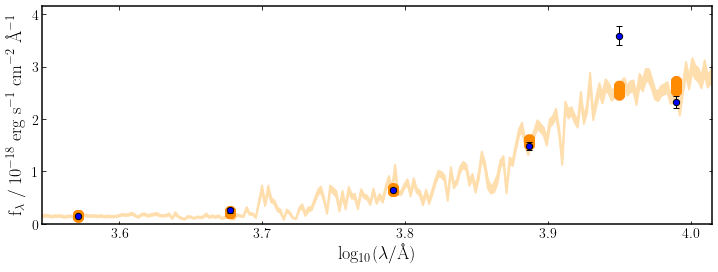

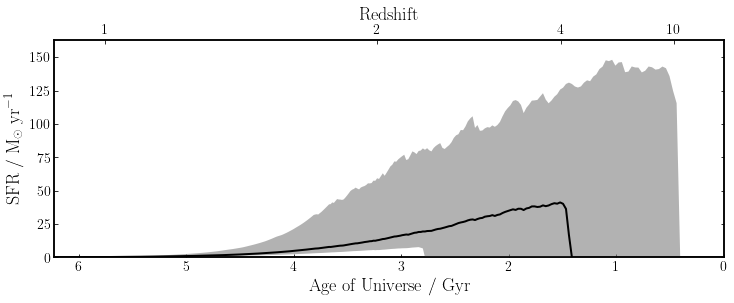

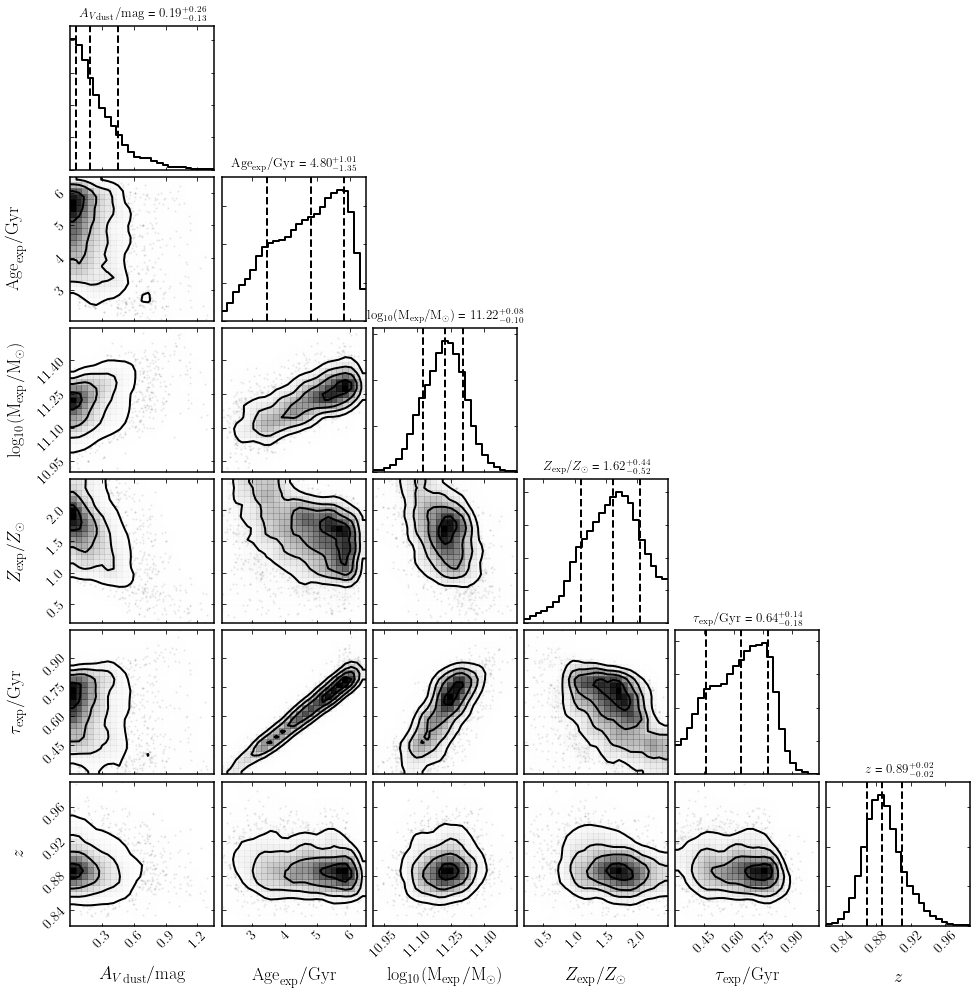

In [23]:
####ADDED
fig = fit3.plot_spectrum_posterior(save=False, show=True)
fig = fit3.plot_sfh_posterior(save=False, show=True)
fig = fit3.plot_corner(save=False, show=True)

### ### photometry data fit from example3

In [24]:
def load_goodss(ID):
    """ Load CANDELS GOODS South photometry from the Guo et al. (2013) catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28,
                                11, 14, 17, 20, 26, 29))
                     #usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                     #         11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :6]
    fluxerrs = cat[row, 6:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

[[6.987040e-02 7.049980e-03]
 [1.923840e-01 4.059220e-02]
 [8.308090e-01 4.154045e-02]
 [2.950840e+00 1.475420e-01]
 [7.377370e+00 3.688685e-01]
 [9.502210e+00 4.751105e-01]]


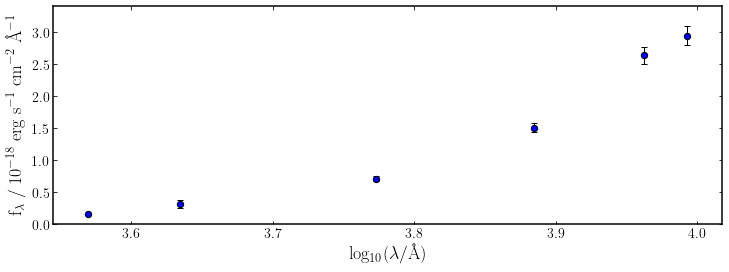

In [25]:
phot = load_goodss("17433")
print(phot)
galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list[:6])
fig = galaxy.plot()

In [10]:
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = (0.0, 10.0)       # Vary observed redshift from 0 to 10
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust


In [215]:
fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)


Bagpipes: fitting object 0360920  


Completed in 65.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        1.938      1.974      1.993
exponential:age                0.103      0.111      0.126
exponential:massformed        10.506     10.535     10.572
exponential:metallicity        2.167      2.368      2.463
exponential:tau                2.203      5.408      8.476




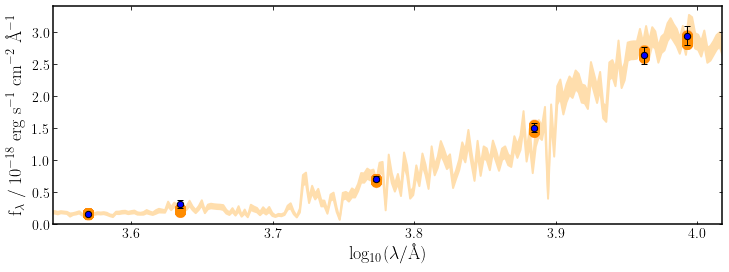

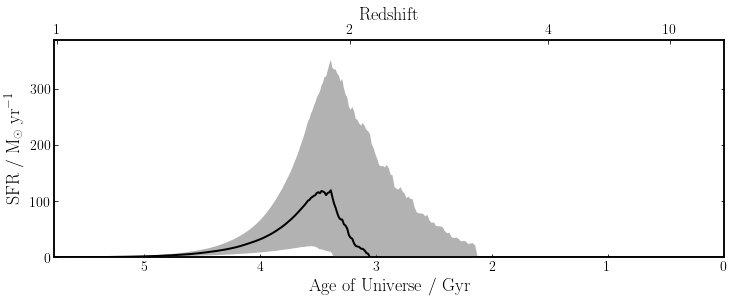

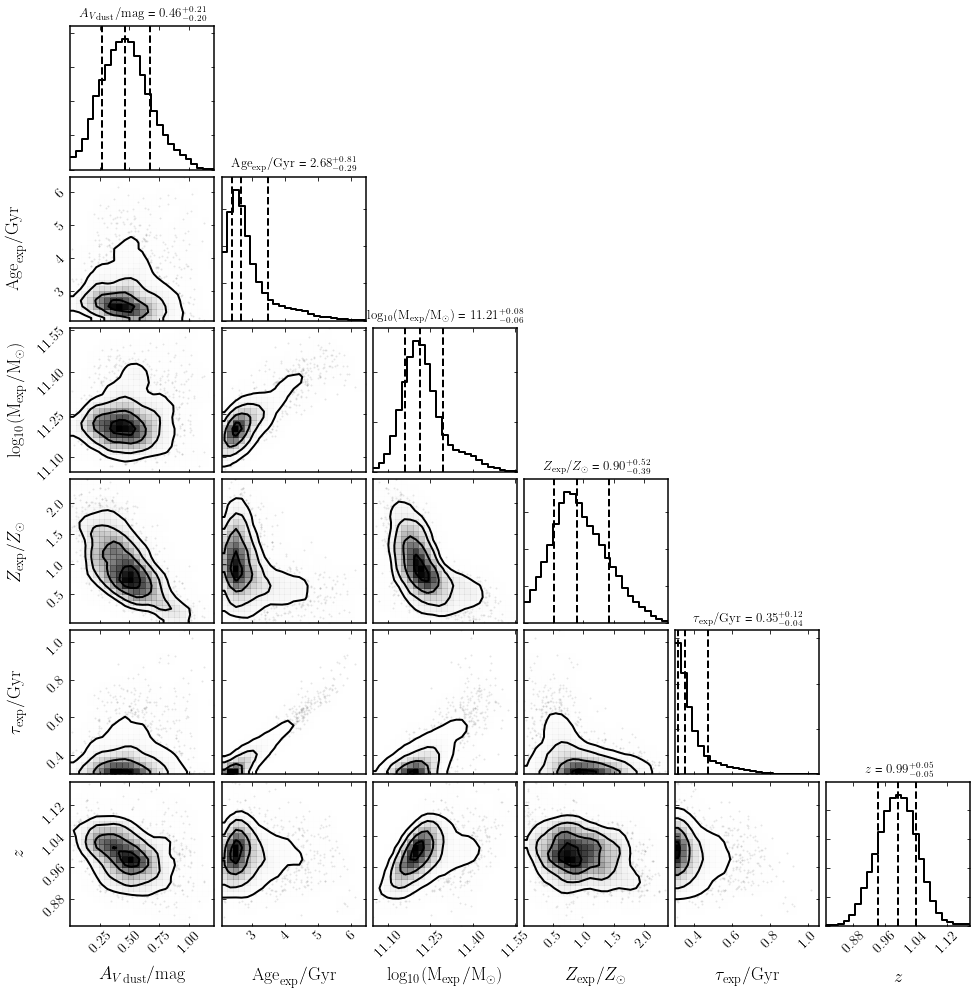

In [28]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

### fitting catalog

In [13]:
IDs = cat['ID'][10:12]

fit_cat = pipes.fit_catalogue(IDs, fit_instructions, load_gal, spectrum_exists=False,
                              cat_filt_list=filt_list, run="pa_cat",redshifts=[1,1],redshift_sigma=[0.01,0.01])

fit_cat.fit(verbose=False)


[[1.0000000e+20]
 [2.5639271e+01]
 [2.5127321e+01]
 [2.4302618e+01]
 [2.4236124e+01]
 [2.4126701e+01]]

Bagpipes: fitting object 0311


Completed in 57.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        1.325      1.532      1.683
exponential:age                0.211      0.291      0.458
exponential:massformed         9.522      9.576      9.648
exponential:metallicity        1.232      1.961      2.326
exponential:tau                2.876      5.829      8.614
redshift                       0.973      0.979      0.990




Bagpipes: 1 out of 2 objects completed.
[[1.0000000e+20]
 [2.5913874e+01]
 [2.5012514e+01]
 [2.5313105e+01]
 [2.5239809e+01]
 [2.4593878e+01]]

Bagpipes: fitting object 0312


Completed in 36.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.167      0.728      1.055
exponential:age                0.139      0.296      1.858
exponential:massformed         9.038      9.172      9.532
exponential:metallicity        0.945      1.605      2.197
exponential:tau                2.937      6.157      8.777
redshift                       0.984      1.005      1.023


Bagpipes: 2 out of 2 objects completed.
